In [1]:
import itertools
import logging
import pathlib
import sys
from typing import Optional

import numpy as np
import pandas as pd
import toml
from copairs.map import run_pipeline
from pycytominer import feature_select

# imports src
sys.path.append("../")
from src import utils

# setting up logger
logging.basicConfig(
    filename="map_analysis_testing.log",
    level=logging.DEBUG,
    format="%(levelname)s:%(asctime)s:%(name)s:%(message)s",
)

## Helper functions
Set of helper functions to help out throughout the notebook

In [2]:
## Helper function


def shuffle_meta_labels(
    dataset: pd.DataFrame, target_col: str, seed: Optional[int] = 0
) -> pd.DataFrame:
    """shuffles labels or values within a single selected column

    Parameters
    ----------
    dataset : pd.DataFrame
        dataframe containing the dataset

    target_col : str
        Column to select in order to conduct the shuffling

    seed : int
        setting random seed

    Returns
    -------
    pd.DataFrame
        shuffled dataset

    Raises
    ------
    TypeError
        raised if incorrect types are provided
    """
    # setting seed
    np.random.seed(seed)

    # type checking
    if not isinstance(target_col, str):
        raise TypeError("'target_col' must be a string type")
    if not isinstance(dataset, pd.DataFrame):
        raise TypeError("'dataset' must be a pandas dataframe")

    # selecting column, shuffle values within column, add to dataframe
    # dataset[target_col] = np.random.permutation(dataset[target_col].values)
    for column in dataset.columns:
        if column == target_col:
            np.random.shuffle(dataset[column].values)
    return dataset


def shuffle_features(feature_vals: np.array, seed: Optional[int] = 0) -> np.array:
    """suffles all values within feature space

    Parameters
    ----------
    feature_vals : np.array
        shuffled

    seed : Optional[int]
        setting random seed

    Returns
    -------
    np.array
        Returns shuffled values within the feature space

    Raises
    ------
    TypeError
        Raised if a numpy array is not provided
    """
    # setting seed
    np.random.seed(seed)

    # shuffle given array
    if not isinstance(feature_vals, np.ndarray):
        raise TypeError("'feature_vals' must be a numpy array")
    if feature_vals.ndim != 2:
        raise TypeError("'feature_vals' must be a 2x2 matrix")

    # creating a copy for feature vales to prevent overwriting of global variables
    feature_vals = np.copy(feature_vals)

    # shuffling feature space
    n_cols = feature_vals.shape[1]
    for col_idx in range(0, n_cols):
        # selecting column, shuffle, and update:
        feature_vals[:, col_idx] = np.random.permutation(feature_vals[:, col_idx])

    return feature_vals

## Setting up Paths and loading data

In [3]:
# load in the treatment groups
ground_truth = pathlib.Path(
    "../../4.sc_Morphology_Neural_Network_MLP_Model/MLP_utils/ground_truth.toml"
).resolve(strict=True)
# load in the ground truth
ground_truth = toml.load(ground_truth)
apoptosis_ground_truth = ground_truth["Apoptosis"]["apoptosis_groups_list"]
pyroptosis_ground_truth = ground_truth["Pyroptosis"]["pyroptosis_groups_list"]
control_ground_truth = ground_truth["Healthy"]["healthy_groups_list"]

In [4]:
single_cell_data = pathlib.Path(
    f"../../data/PBMC_preprocessed_sc_norm_aggregated.parquet"
).resolve(strict=True)
df = pd.read_parquet(single_cell_data)

In [5]:
# out paths
map_out_dir = pathlib.Path("../data/processed/mAP_scores/morphology/")
map_out_dir.mkdir(exist_ok=True, parents=True)

# regular data output
# saving to csv
regular_feat_map_path = pathlib.Path(map_out_dir / "mAP_scores_regular_treatment.csv")

# shuffled data output
shuffled_feat_map_path = pathlib.Path(
    map_out_dir / "mAP_scores_shuffled_class_treatment.csv"
)

# shuffled feature space output
shuffled_feat_space_map_path = pathlib.Path(
    map_out_dir / "mAP_scores_shuffled_feature_space_treatment.csv"
)

### Clean up data

In [6]:
df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique()
# replace values in the oneb_Metadata_Treatment_Dose_Inhibitor_Dose column
df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] = df[
    "oneb_Metadata_Treatment_Dose_Inhibitor_Dose"
].replace(
    "Flagellin_0.100_ug_per_ml_DMSO_0.000_%", "Flagellin_0.100_ug_per_ml_DMSO_0.025_%"
)
df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] = df[
    "oneb_Metadata_Treatment_Dose_Inhibitor_Dose"
].replace("Flagellin_1.000_0_DMSO_0.025_%", "Flagellin_1.000_ug_per_ml_DMSO_0.025_%")
df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] = df[
    "oneb_Metadata_Treatment_Dose_Inhibitor_Dose"
].replace(
    "Flagellin_1.000_ug_per_ml_DMSO_0.000_%", "Flagellin_1.000_ug_per_ml_DMSO_0.025_%"
)
df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] = df[
    "oneb_Metadata_Treatment_Dose_Inhibitor_Dose"
].replace("media_ctr_0.0_0_Media_0_0", "Media")
df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] = df[
    "oneb_Metadata_Treatment_Dose_Inhibitor_Dose"
].replace("media_ctr_0.0_0_Media_ctr_0.0_0", "Media")
df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] = df[
    "oneb_Metadata_Treatment_Dose_Inhibitor_Dose"
].replace(
    "Flagellin_1.000_0_Disulfiram_1.000_uM",
    "Flagellin_1.000_ug_per_ml_Disulfiram_1.000_uM",
)
len(df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique())
# add apoptosis, pyroptosis and healthy columns to dataframe
df["Apoptosis"] = df.apply(
    lambda row: row["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
    in apoptosis_ground_truth,
    axis=1,
)
df["Pyroptosis"] = df.apply(
    lambda row: row["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
    in pyroptosis_ground_truth,
    axis=1,
)
df["Control"] = df.apply(
    lambda row: row["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
    in control_ground_truth,
    axis=1,
)

# merge apoptosis, pyroptosis, and healthy columns into one column
df["Metadata_labels"] = df.apply(
    lambda row: "Apoptosis"
    if row["Apoptosis"]
    else "Pyroptosis"
    if row["Pyroptosis"]
    else "Control",
    axis=1,
)

# # drop apoptosis, pyroptosis, and healthy columns
df.drop(columns=["Apoptosis", "Pyroptosis", "Control"], inplace=True)

In [7]:
# output directories
map_out_dir = pathlib.Path("../data/processed/mAP_scores/")
map_out_dir.mkdir(parents=True, exist_ok=True)

## Define the control df

In [8]:
control_df = df[
    df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] == "DMSO_0.100_%_DMSO_0.025_%"
]
control_df

,Metadata_Well,oneb_Metadata_Treatment_Dose_Inhibitor_Dose,Cytoplasm_AreaShape_Compactness,Cytoplasm_AreaShape_FormFactor,Cytoplasm_AreaShape_MajorAxisLength,Cytoplasm_AreaShape_MinorAxisLength,Cytoplasm_AreaShape_Orientation,Cytoplasm_AreaShape_Zernike_0_0,Cytoplasm_AreaShape_Zernike_1_1,Cytoplasm_AreaShape_Zernike_2_0,...,Nuclei_Texture_InverseDifferenceMoment_CorrMito_3_02_256,Nuclei_Texture_InverseDifferenceMoment_CorrPM_3_00_256,Nuclei_Texture_InverseDifferenceMoment_CorrPM_3_01_256,Nuclei_Texture_InverseDifferenceMoment_CorrPM_3_02_256,Nuclei_Texture_InverseDifferenceMoment_CorrPM_3_03_256,Nuclei_Texture_SumEntropy_CorrPM_3_01_256,Nuclei_Texture_SumVariance_CorrPM_3_01_256,Nuclei_Texture_Variance_CorrER_3_00_256,Nuclei_Texture_Variance_CorrGasdermin_3_00_256,Metadata_labels
4,B06,DMSO_0.100_%_DMSO_0.025_%,0.022371,-0.022614,-0.039573,-0.049300,-0.013386,-0.035579,-0.026341,-0.034624,...,0.279401,0.037046,0.029486,0.030131,0.033986,-0.032881,-0.010667,-0.027280,-0.026652,Control
5,B07,DMSO_0.100_%_DMSO_0.025_%,-0.071753,0.049418,-0.080162,-0.110935,0.009102,0.018723,0.007016,0.008824,...,0.277094,0.017233,0.004765,0.010718,0.006667,-0.009478,-0.006287,0.018806,0.015570,Control
15,C06,DMSO_0.100_%_DMSO_0.025_%,0.061913,-0.047412,0.052250,0.083849,0.024151,-0.026974,-0.013448,-0.005720,...,-0.187934,0.072288,0.079789,0.076412,0.073141,-0.072702,-0.014018,0.001092,0.000683,Control
16,C07,DMSO_0.100_%_DMSO_0.025_%,0.028173,-0.028884,0.053797,0.075352,0.009324,0.011514,0.018833,-0.006253,...,-0.228085,0.024026,0.030745,0.026034,0.028530,-0.034391,-0.008046,0.064628,0.052708,Control
81,I06,DMSO_0.100_%_DMSO_0.025_%,0.048882,-0.014356,0.110362,0.115949,-0.005469,0.024033,0.043835,-0.037867,...,-0.128464,-0.048425,-0.046729,-0.039706,-0.038696,0.052546,0.000737,-0.009176,-0.005408,Control
82,I07,DMSO_0.100_%_DMSO_0.025_%,-0.100867,0.076349,-0.117207,-0.154152,-0.011498,0.024456,-0.014095,0.037949,...,-0.284433,-0.076275,-0.078142,-0.072489,-0.079030,0.068629,0.012430,-0.035163,-0.028315,Control
92,J06,DMSO_0.100_%_DMSO_0.025_%,-0.012228,-0.005155,-0.048954,-0.032680,-0.012399,-0.034741,-0.046950,0.054012,...,0.225380,0.056218,0.057351,0.053801,0.055496,-0.061207,0.003581,-0.020050,-0.017568,Control
93,J07,DMSO_0.100_%_DMSO_0.025_%,-0.000175,0.007426,0.030708,0.024561,-0.001792,0.018262,0.021859,-0.007972,...,0.020434,-0.083589,-0.080232,-0.086812,-0.083429,0.089028,0.021893,0.000990,0.003350,Control


### mAP Pipeline Parameters

The null size needs to be determined for the mAP pipeline. This is the size of the null class that is used to determine the mAP score.

In [9]:
tmp = (
    df.groupby(["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"])
    .count()
    .reset_index()[["Metadata_Well", "oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]]
)
# get the counts of each oneb_Metadata_Treatment_Dose_Inhibitor_Dose
min_count = tmp["Metadata_Well"].min()
print(min_count)

4


Positive pairs: profiles in the same group
Negative pairs: profiles in different groups


pos_sameby = Treatment group: All profiles that have the same treatment group
pos_diffby = Treatment replicates: In this case - wells



In [10]:
pos_sameby = ["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
pos_diffby = ["Metadata_Well"]

neg_sameby = []
neg_diffby = ["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]

# null_size = min_count
null_size = 100000
batch_size = 1

### mAP analysis for non-shuffled data

Loop through the data and determine the mAP score for each treatment in a class compared to a whole other class
Ex. Pyroptosis treatment 1 (LPS 1.0 ug/mL) vs. All Apoptosis treatments  
Ex. Pyroptosis treatment 1 (LPS 1.0 ug/mL) vs. All Control treatments

In [11]:
results_df = pd.DataFrame(
    columns=[
        "Metadata_Well",
        "Metadata_labels",
        "average_precision",
        "p_value",
        "n_pos_pairs",
        "n_total_pairs",
        "shuffled",
        "comparison",
    ]
)

In [12]:
# remove the control group from the dataframe
df = df[
    df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] != "DMSO_0.100_%_DMSO_0.025_%"
]

In [13]:
for i in df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique():
    # manually get treatment
    tmp = df[df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].str.contains(i)]

    # concat tmp and concrol_df
    tmp1 = pd.concat([tmp, control_df])
    print(tmp1["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique())
    # order the oneb_Metadata_Treatment_Dose_Inhibitor_Dose column so that the control group is at the beginning
    tmp1["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] = pd.Categorical(
        tmp1["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"],
        categories=["DMSO_0.100_%_DMSO_0.025_%", i],
        ordered=True,
    )

    # spliting metadata and raw feature values
    logging.info("splitting data set into metadata and raw feature values")
    df_meta, df_feats = utils.split_data(tmp1)
    df_feats = np.array(df_feats)
    try:
        # execute pipeline on negative control with trianing dataset with cp features

        logging.info(f"Running pipeline on CP features using phenotype")
        result = run_pipeline(
            meta=df_meta,
            feats=df_feats,
            pos_sameby=pos_sameby,
            pos_diffby=pos_diffby,
            neg_sameby=neg_sameby,
            neg_diffby=neg_diffby,
            batch_size=batch_size,
            null_size=null_size,
        )

        result["shuffled"] = "non-shuffled"
        result["comparison"] = i

    except ZeroDivisionError as e:
        logging.warning(f"{e} captured on phenotye:. Skipping")

    # concatenating all datasets
    results_df = pd.concat([results_df, result], axis=0)
results_df.to_csv(regular_feat_map_path, index=False)

['LPS_0.010_ug_per_ml_DMSO_0.025_%' 'DMSO_0.100_%_DMSO_0.025_%']


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

['LPS_Nigericin_100.000_ug_per_ml_1.000_uM_DMSO_0.025_%'
 'DMSO_0.100_%_DMSO_0.025_%']


/tmp/ipykernel_780873/3734974114.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, result], axis=0)


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

['Media' 'DMSO_0.100_%_DMSO_0.025_%']


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

['LPS_0.100_ug_per_ml_DMSO_0.025_%' 'DMSO_0.100_%_DMSO_0.025_%']


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

['LPS_Nigericin_100.000_ug_per_ml_3.000_uM_DMSO_0.025_%'
 'DMSO_0.100_%_DMSO_0.025_%']


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

['DMSO_0.100_%_DMSO_1.000_%' 'DMSO_0.100_%_DMSO_0.025_%']


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

['LPS_1.000_ug_per_ml_DMSO_0.025_%' 'DMSO_0.100_%_DMSO_0.025_%']


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

['LPS_Nigericin_100.000_ug_per_ml_10.000_uM_DMSO_0.025_%'
 'DMSO_0.100_%_DMSO_0.025_%']


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

['Thapsigargin_1.000_uM_DMSO_0.025_%' 'DMSO_0.100_%_DMSO_0.025_%']


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

['DMSO_0.100_%_Z-VAD-FMK_100.000_uM' 'DMSO_0.100_%_DMSO_0.025_%']


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

['LPS_10.000_ug_per_ml_DMSO_0.025_%' 'DMSO_0.100_%_DMSO_0.025_%']


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

['Disulfiram_0.100_uM_DMSO_0.025_%' 'DMSO_0.100_%_DMSO_0.025_%']


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

['Thapsigargin_10.000_uM_DMSO_0.025_%' 'DMSO_0.100_%_DMSO_0.025_%']


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

['DMSO_0.100_%_Z-VAD-FMK_30.000_uM' 'DMSO_0.100_%_DMSO_0.025_%']


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

['LPS_10.000_ug_per_ml_Disulfiram_0.100_uM' 'DMSO_0.100_%_DMSO_0.025_%']


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

['Disulfiram_1.000_uM_DMSO_0.025_%' 'DMSO_0.100_%_DMSO_0.025_%']


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

['Topotecan_5.000_nM_DMSO_0.025_%' 'DMSO_0.100_%_DMSO_0.025_%']


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

['LPS_10.000_ug_per_ml_Disulfiram_1.000_uM' 'DMSO_0.100_%_DMSO_0.025_%']


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

['Disulfiram_2.500_uM_DMSO_0.025_%' 'DMSO_0.100_%_DMSO_0.025_%']


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

['Topotecan_10.000_nM_DMSO_0.025_%' 'DMSO_0.100_%_DMSO_0.025_%']


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

['LPS_10.000_ug_per_ml_Disulfiram_2.500_uM' 'DMSO_0.100_%_DMSO_0.025_%']


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

['H2O2_100.000_nM_DMSO_0.025_%' 'DMSO_0.100_%_DMSO_0.025_%']


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

['Topotecan_20.000_nM_DMSO_0.025_%' 'DMSO_0.100_%_DMSO_0.025_%']


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

['LPS_10.000_ug_per_ml_Z-VAD-FMK_100.000_uM' 'DMSO_0.100_%_DMSO_0.025_%']


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

['H2O2_100.000_uM_DMSO_0.025_%' 'DMSO_0.100_%_DMSO_0.025_%']


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

['LPS_100.000_ug_per_ml_DMSO_0.025_%' 'DMSO_0.100_%_DMSO_0.025_%']


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

['H2O2_100.000_uM_Disulfiram_1.000_uM' 'DMSO_0.100_%_DMSO_0.025_%']


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

['LPS_Nigericin_1.000_ug_per_ml_1.000_uM_DMSO_0.025_%'
 'DMSO_0.100_%_DMSO_0.025_%']


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

['H2O2_100.000_uM_Z-VAD-FMK_100.000_uM' 'DMSO_0.100_%_DMSO_0.025_%']


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

['LPS_Nigericin_1.000_ug_per_ml_3.000_uM_DMSO_0.025_%'
 'DMSO_0.100_%_DMSO_0.025_%']


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

['Flagellin_0.100_ug_per_ml_DMSO_0.025_%' 'DMSO_0.100_%_DMSO_0.025_%']


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

['LPS_Nigericin_1.000_ug_per_ml_10.000_uM_DMSO_0.025_%'
 'DMSO_0.100_%_DMSO_0.025_%']


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

['Flagellin_1.000_ug_per_ml_DMSO_0.025_%' 'DMSO_0.100_%_DMSO_0.025_%']


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

['LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Disulfiram_1.000_uM'
 'DMSO_0.100_%_DMSO_0.025_%']


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

['Flagellin_1.000_ug_per_ml_Disulfiram_1.000_uM'
 'DMSO_0.100_%_DMSO_0.025_%']


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

['LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Z-VAD-FMK_100.000_uM'
 'DMSO_0.100_%_DMSO_0.025_%']


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [14]:
result

,Metadata_Well,oneb_Metadata_Treatment_Dose_Inhibitor_Dose,Metadata_labels,average_precision,p_value,n_pos_pairs,n_total_pairs,shuffled,comparison
0,O02,LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Z-VAD-...,Control,1.000000,0.006230,3.0,11.0,non-shuffled,LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Z-VAD-...
1,O03,LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Z-VAD-...,Control,1.000000,0.006230,3.0,11.0,non-shuffled,LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Z-VAD-...
2,O08,LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Z-VAD-...,Control,1.000000,0.006230,3.0,11.0,non-shuffled,LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Z-VAD-...
3,O09,LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Z-VAD-...,Control,1.000000,0.006230,3.0,11.0,non-shuffled,LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Z-VAD-...
4,B06,DMSO_0.100_%_DMSO_0.025_%,Control,0.674356,0.593474,7.0,11.0,non-shuffled,LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Z-VAD-...
5,B07,DMSO_0.100_%_DMSO_0.025_%,Control,0.588642,0.830082,7.0,11.0,non-shuffled,LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Z-VAD-...
6,C06,DMSO_0.100_%_DMSO_0.025_%,Control,0.720274,0.450435,7.0,11.0,non-shuffled,LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Z-VAD-...
7,C07,DMSO_0.100_%_DMSO_0.025_%,Control,0.837338,0.162848,7.0,11.0,non-shuffled,LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Z-VAD-...
8,I06,DMSO_0.100_%_DMSO_0.025_%,Control,0.766193,0.326377,7.0,11.0,non-shuffled,LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Z-VAD-...
9,I07,DMSO_0.100_%_DMSO_0.025_%,Control,0.598846,0.811652,7.0,11.0,non-shuffled,LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Z-VAD-...


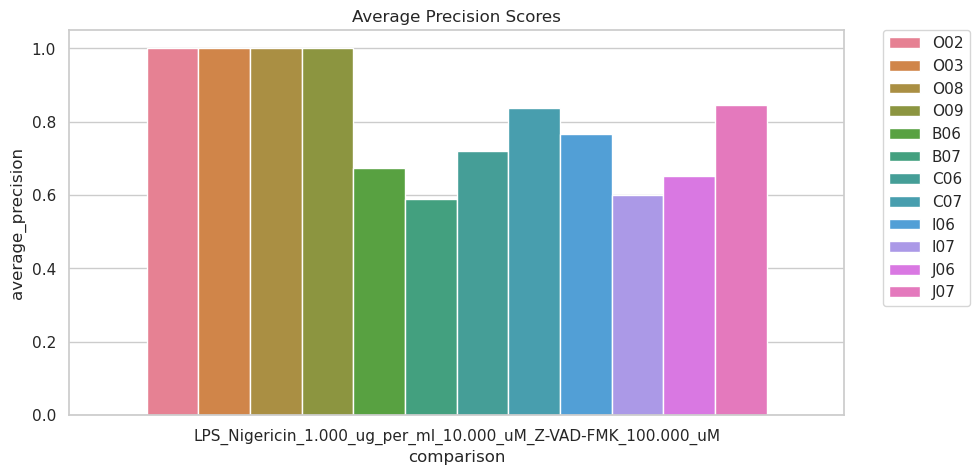

In [15]:
import matplotlib.pyplot as plt

# plot the average precision scores on a number line
import seaborn as sns

# plot the average precision scores
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
ax = sns.barplot(
    x="comparison", y="average_precision", hue="Metadata_Well", data=result
)
plt.title("Average Precision Scores")
# legend on the right
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

In [16]:
results_df.head(15)

,Metadata_Well,Metadata_labels,average_precision,p_value,n_pos_pairs,n_total_pairs,shuffled,comparison,oneb_Metadata_Treatment_Dose_Inhibitor_Dose
0,B02,Pyroptosis,1.000000,0.006230,3.0,11.0,non-shuffled,LPS_0.010_ug_per_ml_DMSO_0.025_%,LPS_0.010_ug_per_ml_DMSO_0.025_%
1,B03,Pyroptosis,0.588889,0.170458,3.0,11.0,non-shuffled,LPS_0.010_ug_per_ml_DMSO_0.025_%,LPS_0.010_ug_per_ml_DMSO_0.025_%
2,B08,Pyroptosis,1.000000,0.006230,3.0,11.0,non-shuffled,LPS_0.010_ug_per_ml_DMSO_0.025_%,LPS_0.010_ug_per_ml_DMSO_0.025_%
3,B09,Pyroptosis,1.000000,0.006230,3.0,11.0,non-shuffled,LPS_0.010_ug_per_ml_DMSO_0.025_%,LPS_0.010_ug_per_ml_DMSO_0.025_%
4,B06,Control,0.674356,0.593474,7.0,11.0,non-shuffled,LPS_0.010_ug_per_ml_DMSO_0.025_%,DMSO_0.100_%_DMSO_0.025_%
5,B07,Control,0.507689,0.970480,7.0,11.0,non-shuffled,LPS_0.010_ug_per_ml_DMSO_0.025_%,DMSO_0.100_%_DMSO_0.025_%
6,C06,Control,0.766759,0.323167,7.0,11.0,non-shuffled,LPS_0.010_ug_per_ml_DMSO_0.025_%,DMSO_0.100_%_DMSO_0.025_%
7,C07,Control,0.859617,0.120329,7.0,11.0,non-shuffled,LPS_0.010_ug_per_ml_DMSO_0.025_%,DMSO_0.100_%_DMSO_0.025_%
8,I06,Control,0.785637,0.277887,7.0,11.0,non-shuffled,LPS_0.010_ug_per_ml_DMSO_0.025_%,DMSO_0.100_%_DMSO_0.025_%
9,I07,Control,0.503608,0.979340,7.0,11.0,non-shuffled,LPS_0.010_ug_per_ml_DMSO_0.025_%,DMSO_0.100_%_DMSO_0.025_%


### mAP analysis for shuffled data (Feature space)

In [17]:
results_df = pd.DataFrame(
    columns=[
        "Metadata_Well",
        "Metadata_labels",
        "average_precision",
        "p_value",
        "n_pos_pairs",
        "n_total_pairs",
        "shuffled",
        "comparison",
    ]
)

In [18]:
for i in df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique():
    # manually get treatment
    tmp = df[
        df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].str.contains(i)
    ].reset_index(drop=True)

    # concat tmp and concrol_df
    tmp1 = pd.concat([tmp, control_df]).reset_index(drop=True)

    # spliting metadata and raw feature values
    logging.info("splitting data set into metadata and raw feature values")
    df_meta, df_feats = utils.split_data(tmp1)
    df_feats = np.array(df_feats)
    seed = np.random.randint(0, 100)

    # shuffling the features, this will overwrite the generated feature space from above with the shuffled one
    df_feats = shuffle_features(feature_vals=df_feats, seed=seed)

    try:
        # execute pipeline on negative control with trianing dataset with cp features

        logging.info(f"Running pipeline on CP features using phenotype")
        result = run_pipeline(
            meta=df_meta,
            feats=df_feats,
            pos_sameby=pos_sameby,
            pos_diffby=pos_diffby,
            neg_sameby=neg_sameby,
            neg_diffby=neg_diffby,
            batch_size=batch_size,
            null_size=null_size,
        )

        result["shuffled"] = "shuffled"
        result["comparison"] = i

    except ZeroDivisionError as e:
        logging.warning(f"{e} captured on phenotye:. Skipping")

        # concatenating all datasets
    results_df = pd.concat([results_df, result], ignore_index=True)
# saving to csv
results_df.to_csv(shuffled_feat_space_map_path, index=False)
results_df.head(10)

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

/tmp/ipykernel_780873/1784065866.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, result], ignore_index=True)


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

,Metadata_Well,Metadata_labels,average_precision,p_value,n_pos_pairs,n_total_pairs,shuffled,comparison,oneb_Metadata_Treatment_Dose_Inhibitor_Dose
0,B02,Pyroptosis,0.324242,0.617854,3.0,11.0,shuffled,LPS_0.010_ug_per_ml_DMSO_0.025_%,LPS_0.010_ug_per_ml_DMSO_0.025_%
1,B03,Pyroptosis,0.833333,0.019000,3.0,11.0,shuffled,LPS_0.010_ug_per_ml_DMSO_0.025_%,LPS_0.010_ug_per_ml_DMSO_0.025_%
2,B08,Pyroptosis,0.444444,0.368446,3.0,11.0,shuffled,LPS_0.010_ug_per_ml_DMSO_0.025_%,LPS_0.010_ug_per_ml_DMSO_0.025_%
3,B09,Pyroptosis,0.331650,0.605484,3.0,11.0,shuffled,LPS_0.010_ug_per_ml_DMSO_0.025_%,LPS_0.010_ug_per_ml_DMSO_0.025_%
4,B06,Control,0.837338,0.162848,7.0,11.0,shuffled,LPS_0.010_ug_per_ml_DMSO_0.025_%,DMSO_0.100_%_DMSO_0.025_%
5,B07,Control,0.927644,0.029550,7.0,11.0,shuffled,LPS_0.010_ug_per_ml_DMSO_0.025_%,DMSO_0.100_%_DMSO_0.025_%
6,C06,Control,0.725000,0.441656,7.0,11.0,shuffled,LPS_0.010_ug_per_ml_DMSO_0.025_%,DMSO_0.100_%_DMSO_0.025_%
7,C07,Control,0.565512,0.882041,7.0,11.0,shuffled,LPS_0.010_ug_per_ml_DMSO_0.025_%,DMSO_0.100_%_DMSO_0.025_%
8,I06,Control,0.763131,0.338687,7.0,11.0,shuffled,LPS_0.010_ug_per_ml_DMSO_0.025_%,DMSO_0.100_%_DMSO_0.025_%
9,I07,Control,0.580442,0.845302,7.0,11.0,shuffled,LPS_0.010_ug_per_ml_DMSO_0.025_%,DMSO_0.100_%_DMSO_0.025_%
